In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census

# Census API Key
from config import api_key
c = Census(api_key, year=2017)

In [2]:
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

In [17]:
# Load mapping of Chicago zipcode to Chicago city area into DataFrame

# Set location of mapping file
mapping_file = "../Data/zipcode_to_area_map.csv"

# Create DataFrame
df_zip_to_area_map = pd.read_csv(mapping_file)
df_zip_to_area_map = df_zip_to_area_map.astype(str)

df_zip_to_area_map.head()


,Zipcode,Area
0,60601,Central
1,60602,Central
2,60603,Central
3,60604,Central
4,60605,Central


In [18]:
# Load successful restaurant information into a DataFrame

# Set location of mapping file
yelp_file = "../Data/Yelp_Restaurants_Chicago.csv"

# Create DataFrame
df_yelp = pd.read_csv(yelp_file)
df_yelp = df_yelp.astype({'zip': str}) 

# Filter for successful marketing channel campaigns, defined as 4 star rating or better
df_yelp_success = df_yelp.loc[df_yelp['rating'] >= 4, :]

# Add Chicago city area to table to support visualization
df_yelp_success_area = pd.merge(df_yelp_success, df_zip_to_area_map, left_on = 'zip', right_on = 'Zipcode', how = 'left')

# Group by Chicago city area and get count of ratings meeting success criteria
success_grp_zip = df_yelp_success_area.groupby(['zip'])
df_success_group_zip = pd.DataFrame(success_grp_zip['name'].count())
df_success_group_zip = df_success_group_zip.rename(columns = {'name': 'success_count'})

df_success_group_zip.head()

,success_count
zip,
60601,4
60602,9
60603,13
60604,2
60605,24


In [19]:
# Group by Chicago city area and get count of ratings meeting success criteria
success_grp_area = df_yelp_success_area.groupby(['Area'])
df_success_group_area = pd.DataFrame(success_grp_area['name'].count())
df_success_group_area = df_success_group_area.rename(columns = {'name': 'success_count'})

df_success_group_area.head()


,success_count
Area,
Central,258
Far North Side,265
Far South East Side,24
Far South West Side,19
North Side,241


In [20]:
# Create zipcode table to filter Census data to only Chicago zipcodes 

# Create series of Chicago zipcodes
chi_zip = ['60666','60686']

chi_seq = 60601

for i in range(56):
    chi_zip.append(str(chi_seq))
    
    # skip invalid zipcodes
    if chi_seq in ([60626, 60634, 60647, 60649, 60657]):
        chi_seq += 1
        
    chi_seq += 1
    i += 1

# Create Chicago zipcode DataFrame
df_chi_zip = pd.DataFrame(data=chi_zip)
df_chi_zip.rename(columns = {0:"Zipcode"}, inplace=True)

df_chi_zip.head()



,Zipcode
0,60666
1,60686
2,60601
3,60602
4,60603


In [21]:
# Run Census Search to retrieve general data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E", 
                          "B19301_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_general = pd.DataFrame(census_data)

# Column Reordering
df_census_general = df_census_general.rename(columns={"B01003_001E": "Population",
                                                      "B01002_001E": "Median Age",
                                                      "B19013_001E": "Median Household Income",
                                                      "B19301_001E": "Per Capita Income",
                                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
df_census_general["Poverty Rate"] = 100 * \
    df_census_general["Poverty Count"].astype(
        int) / df_census_general["Population"].astype(int)

# Final DataFrame
df_census_general = df_census_general[["Zipcode", "Population", "Median Age", "Median Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate"]]

# Visualize
print(len(df_census_general))
df_census_general.head()


33120


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,00601,17599.0,38.9,11757.0,7041.0,11282.0,64.105915
1,00602,39209.0,40.9,16190.0,8978.0,20428.0,52.100283
2,00603,50135.0,40.4,16645.0,10897.0,25176.0,50.216416
3,00606,6304.0,42.8,13387.0,5960.0,4092.0,64.911168
4,00610,27590.0,41.4,18741.0,9266.0,12553.0,45.498369


In [22]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant general data set
# and drop n/a zipcodes with no statistics
df_chi_general = pd.merge(df_census_general, df_chi_zip, on='Zipcode', how = 'right')
df_chi_general = df_chi_general.dropna(how="any")

print(len(df_chi_general))
df_chi_general.head()


56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471


In [24]:
# add city area to general information based on zipcode
df_chi_general_area = pd.merge(df_chi_general, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left')

print(len(df_chi_general_area))
df_chi_general_area.head()

56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate,Area
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347,Central
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873,Central
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511,Central
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976,Central
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471,Central


In [25]:
# add success counts to general data based on zipcode
df_chi_general_area = pd.merge(df_chi_general_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_general_area))
df_chi_general_area.head()

56


,Zipcode,Population,Median Age,Median Household Income,Per Capita Income,Poverty Count,Poverty Rate,Area,success_count
0,60601,13887.0,37.6,110215.0,95152.0,1171.0,8.432347,Central,4.0
1,60602,1277.0,31.1,115774.0,77279.0,32.0,2.505873,Central,9.0
2,60603,1197.0,26.7,140114.0,106207.0,261.0,21.804511,Central,13.0
3,60604,668.0,40.6,114565.0,130966.0,127.0,19.011976,Central,2.0
4,60605,26188.0,33.6,107811.0,81144.0,2312.0,8.828471,Central,24.0


In [26]:
# Save general data as a csv

df_chi_general_area.to_csv("../Data/census_general.csv", encoding="utf-8", index=False)

In [27]:
# Run Census Search to retrieve race data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B02001_001E", "B02001_002E", "B02001_003E", "B02001_004E",
                          "B02001_005E", "B02001_006E", "B02001_007E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_race = pd.DataFrame(census_data)

# Column Reordering
df_census_race = df_census_race.rename(columns={"B02001_001E": "Total",
                                                "B02001_002E": "White", 
                                                "B02001_003E": "Black",
                                                "B02001_004E": "Native American",
                                                "B02001_005E": "Asian",
                                                "B02001_006E": "Pacific Islander",
                                                "B02001_007E": "Other",
                                                  "NAME": "Name", "zip code tabulation area": "Zipcode"})
# Final DataFrame
df_census_race = df_census_race[["Zipcode", "Total", "White", "Black", "Native American", "Asian", 
                                    "Pacific Islander", "Other"]]

# Visualize
print(len(df_census_race))
df_census_race.head()


33120


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other
0,84306,345.0,345.0,0.0,0.0,0.0,0.0,0.0
1,84775,421.0,419.0,0.0,0.0,0.0,0.0,0.0
2,84762,211.0,211.0,0.0,0.0,0.0,0.0,0.0
3,84772,203.0,203.0,0.0,0.0,0.0,0.0,0.0
4,84781,224.0,224.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant race data set
# and drop n/a zipcodes with no statistics
df_chi_race = pd.merge(df_census_race, df_chi_zip, on='Zipcode', how = 'right')
df_chi_race = df_chi_race.dropna(how="any")

print(len(df_chi_race))
df_chi_race.head()

56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0


In [29]:
# add city area to race information based on zipcode
df_chi_race_area = pd.merge(df_chi_race, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_race_area))
df_chi_race_area.head()


56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other,Area
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0,Central
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0,South Side
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0,Far North Side
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0,Far North Side
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0,Far South West Side


In [30]:
# add success counts to race data based on zipcode
df_chi_race_area = pd.merge(df_chi_race_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_race_area))
df_chi_race_area.head()

56


,Zipcode,Total,White,Black,Native American,Asian,Pacific Islander,Other,Area,success_count
0,60607,28928.0,17396.0,3681.0,30.0,6399.0,26.0,377.0,Central,52.0
1,60609,60994.0,29002.0,14628.0,402.0,3755.0,12.0,11885.0,South Side,2.0
2,60625,80676.0,53120.0,3981.0,112.0,11272.0,41.0,8098.0,Far North Side,58.0
3,60646,27865.0,23611.0,246.0,6.0,2713.0,0.0,745.0,Far North Side,16.0
4,60652,43582.0,11459.0,20510.0,133.0,325.0,12.0,9717.0,Far South West Side,6.0


In [31]:
# Save race data as a csv

df_chi_race_area.to_csv("../Data/census_race.csv", encoding="utf-8", index=False)

In [32]:
# Run Census Search to retrieve education level data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B06009_001E", "B06009_002E", "B06009_003E", 
                          "B06009_004E", "B06009_005E", "B06009_006E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_education_level = pd.DataFrame(census_data)

# Column Reordering
df_census_education_level = df_census_education_level.rename(columns={"B06009_001E": "Total",
                                                      "B06009_002E": "Less than HS",
                                                      "B06009_003E": "High School",
                                                      "B06009_004E": "Some College Assoc Degree",
                                                      "B06009_005E": "Bachelor Degree",
                                                      "B06009_006E": "Grad Degree or PHD",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_education_level = df_census_education_level[["Zipcode", "Total", "Less than HS", "High School",
                       "Some College Assoc Degree", "Bachelor Degree", "Grad Degree or PHD"]]

# Visualize
print(len(df_census_education_level))
df_census_education_level.head()

33120


,Zipcode,Total,Less than HS,High School,Some College Assoc Degree,Bachelor Degree,Grad Degree or PHD
0,84306,204.0,0.0,41.0,110.0,35.0,18.0
1,84775,343.0,61.0,52.0,76.0,71.0,83.0
2,84762,168.0,0.0,93.0,31.0,22.0,22.0
3,84772,142.0,26.0,61.0,41.0,6.0,8.0
4,84781,126.0,0.0,23.0,15.0,88.0,0.0


In [33]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant education level data set
# and drop n/a zipcodes with no statistics
df_chi_education_level = pd.merge(df_census_education_level, df_chi_zip, on='Zipcode', how = 'right')
df_chi_education_level = df_chi_education_level.dropna(how="any")

print(len(df_chi_education_level))
df_chi_education_level.head()

56


,Zipcode,Total,Less than HS,High School,Some College Assoc Degree,Bachelor Degree,Grad Degree or PHD
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0


In [34]:
# add city area to education level information based on zipcode
df_chi_education_level_area = pd.merge(df_chi_education_level, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_education_level_area))
df_chi_education_level_area.head()

56


,Zipcode,Total,Less than HS,High School,Some College Assoc Degree,Bachelor Degree,Grad Degree or PHD,Area
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side


In [35]:
# add success counts to education level data based on zipcode
df_chi_education_level_area = pd.merge(df_chi_education_level_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_education_level_area))
df_chi_education_level_area.head()

56


,Zipcode,Total,Less than HS,High School,Some College Assoc Degree,Bachelor Degree,Grad Degree or PHD,Area,success_count
0,60607,19377.0,903.0,1359.0,1938.0,7661.0,7516.0,Central,52.0
1,60609,37530.0,10055.0,15022.0,7556.0,3161.0,1736.0,South Side,2.0
2,60625,57018.0,8863.0,10062.0,10686.0,17244.0,10163.0,Far North Side,58.0
3,60646,20025.0,1382.0,3722.0,4255.0,6499.0,4167.0,Far North Side,16.0
4,60652,27213.0,4168.0,8216.0,9108.0,3710.0,2011.0,Far South West Side,6.0


In [37]:
# Save education level data as a csv

df_chi_education_level_area.to_csv("../Data/census_education_level.csv", encoding="utf-8", index=False)

NameError: name 'df_total_rides_u' is not defined

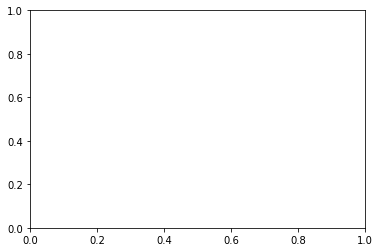

In [38]:
#**********************************************************
# Build the scatter plot for duration vs zipcode with education level as dura
fig1, ax = plt.subplots()

#fig = plt.figure()
ax1 = plt.scatter(df_total_rides_u, df_avg_fare_u, marker="o", facecolors='lightcoral', edgecolors="black", s=df_drivers_u*3, linewidths = 1, alpha=0.75)
ax2 = plt.scatter(df_total_rides_s, df_avg_fare_s, marker="o", facecolors='lightskyblue', edgecolors="black", s=df_drivers_s*3, linewidths = 1, alpha=0.75)
ax3 = plt.scatter(df_total_rides_r, df_avg_fare_r, marker="o", facecolors='gold', edgecolors="black", s=df_drivers_r*3, linewidths = 1, alpha = 0.75)

# Incorporate the other graph properties
plt.xlabel("Total Number of Rides (Per City)")
plt.ylabel("Average Fare $")
plt.text(45,40,'Note:\nBubble Size Correlates witlt.figure(figsize=(20,10))h Driver Count per City.',multialignment = 'left')
plt.grid()
lgnd = plt.legend((ax1, ax2, ax3), ('Urban', 'Suburban', 'Rural'), title = 'City Types')
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]

ax.set_title("Pyber Ride Sharing Data (2016)")
fig1.set_size_inches(7,5)

# Save Figure
plt.savefig("output/scatter.png")

# Show plot
plt.show()


In [39]:
# Run Census Search to retrieve household size data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B08201_007E", "B08201_013E", "B08201_019E", 
                          "B08201_025E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_household_size = pd.DataFrame(census_data)

# Column Reordering
df_census_household_size = df_census_household_size.rename(columns={"B08201_007E": "1 Person",
                                                      "B08201_013E": "2 People",
                                                      "B08201_019E": "3 People",
                                                      "B08201_025E": "4 or More People",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_household_size = df_census_household_size[["Zipcode", "1 Person", "2 People", "3 People", "4 or More People"]]

# Visualize
print(len(df_census_household_size))
df_census_household_size.head()


33120


,Zipcode,1 Person,2 People,3 People,4 or More People
0,84306,13.0,37.0,54.0,28.0
1,84775,65.0,87.0,21.0,14.0
2,84762,10.0,22.0,0.0,31.0
3,84772,39.0,14.0,27.0,9.0
4,84781,22.0,17.0,0.0,35.0


In [40]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant education level data set
# and drop n/a zipcodes with no statistics
df_chi_household_size = pd.merge(df_census_household_size, df_chi_zip, on='Zipcode', how = 'right')
df_chi_household_size = df_chi_household_size.dropna(how="any")

print(len(df_chi_household_size))
df_chi_household_size.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People
0,60607,5435.0,4636.0,1461.0,1131.0
1,60609,5610.0,4756.0,3504.0,6090.0
2,60625,8773.0,8862.0,5085.0,6725.0
3,60646,3298.0,3325.0,1469.0,2667.0
4,60652,2675.0,3305.0,2518.0,4713.0


In [41]:
# add city area to household size information based on zipcode
df_chi_household_size_area = pd.merge(df_chi_household_size, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_household_size_area))
df_chi_household_size_area.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People,Area
0,60607,5435.0,4636.0,1461.0,1131.0,Central
1,60609,5610.0,4756.0,3504.0,6090.0,South Side
2,60625,8773.0,8862.0,5085.0,6725.0,Far North Side
3,60646,3298.0,3325.0,1469.0,2667.0,Far North Side
4,60652,2675.0,3305.0,2518.0,4713.0,Far South West Side


In [42]:
# add success counts to household size data based on zipcode
df_chi_household_size_area = pd.merge(df_chi_household_size_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_household_size_area))
df_chi_household_size_area.head()

56


,Zipcode,1 Person,2 People,3 People,4 or More People,Area,success_count
0,60607,5435.0,4636.0,1461.0,1131.0,Central,52.0
1,60609,5610.0,4756.0,3504.0,6090.0,South Side,2.0
2,60625,8773.0,8862.0,5085.0,6725.0,Far North Side,58.0
3,60646,3298.0,3325.0,1469.0,2667.0,Far North Side,16.0
4,60652,2675.0,3305.0,2518.0,4713.0,Far South West Side,6.0


In [43]:
# Save household size data as a csv

df_chi_household_size_area.to_csv("../Data/census_household_size.csv", encoding="utf-8", index=False)

In [45]:
# Run Census Search to retrieve marital status data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B06008_001E", "B06008_002E", "B06008_003E", 
                          "B06008_004E", "B06008_005E", "B06008_006E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_marital_status = pd.DataFrame(census_data)

# Column Reordering
df_census_marital_status = df_census_marital_status.rename(columns={"B06008_001E": "Total",
                                                      "B06008_002E": "Never Married",
                                                      "B06008_003E": "Married",
                                                      "B06008_004E": "Divorced",
                                                      "B06008_005E": "Separated",
                                                      "B06008_006E": "Widowed",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_marital_status = df_census_marital_status[["Zipcode", "Total", "Never Married", "Married",
                       "Divorced", "Separated", "Widowed"]]

# Visualize
print(len(df_census_marital_status))
df_census_marital_status.head()

33120


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed
0,84306,258.0,34.0,211.0,13.0,0.0,0.0
1,84775,373.0,41.0,261.0,44.0,0.0,27.0
2,84762,187.0,19.0,158.0,0.0,0.0,10.0
3,84772,180.0,38.0,103.0,0.0,26.0,13.0
4,84781,159.0,33.0,119.0,0.0,0.0,7.0


In [46]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant marital status data set
# and drop n/a zipcodes with no statistics
df_chi_marital_status = pd.merge(df_census_marital_status, df_chi_zip, on='Zipcode', how = 'right')
df_chi_marital_status = df_chi_marital_status.dropna(how="any")

print(len(df_chi_marital_status))
df_chi_marital_status.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0


In [47]:
# add city area to marital status information based on zipcode
df_chi_marital_status_area = pd.merge(df_chi_marital_status, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_marital_status_area))
df_chi_marital_status_area.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed,Area
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0,Central
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0,South Side
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0,Far North Side
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0,Far North Side
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0,Far South West Side


In [48]:
# add success counts to marital status data based on zipcode
df_chi_marital_status_area = pd.merge(df_chi_marital_status_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_marital_status_area))
df_chi_marital_status_area.head()

56


,Zipcode,Total,Never Married,Married,Divorced,Separated,Widowed,Area,success_count
0,60607,26242.0,16181.0,7900.0,1595.0,139.0,427.0,Central,52.0
1,60609,46985.0,22570.0,16414.0,3319.0,1707.0,2975.0,South Side,2.0
2,60625,66691.0,29786.0,28691.0,4804.0,1065.0,2345.0,Far North Side,58.0
3,60646,22336.0,5645.0,12903.0,1844.0,291.0,1653.0,Far North Side,16.0
4,60652,33967.0,14010.0,14455.0,3039.0,676.0,1787.0,Far South West Side,6.0


In [49]:
# Save marital status data as a csv

df_chi_marital_status_area.to_csv("../Data/census_marital_status.csv", encoding="utf-8", index=False)

In [50]:
# Run Census Search to retrieve work transportation data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B08006_001E", "B08006_002E", "B08006_003E", "B08006_004E", "B08006_005E", 
                          "B08006_006E","B08006_007E", "B08006_008E", "B08006_009E", "B08006_010E", "B08006_011E", 
                          "B08006_012E","B08006_013E", "B08006_014E", 
                          "B08006_015E", "B08006_016E", "B08006_017E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_work_transport = pd.DataFrame(census_data)

# Column Reordering
df_census_work_transport = df_census_work_transport.rename(columns={"B08006_001E": "Total",
                                                      "B08006_002E": "Car Truck Van",
                                                      "B08006_003E": "Drove Alone",
                                                      "B08006_004E": "Carpool",
                                                      "B08006_005E": "Carpool 2 People",
                                                      "B08006_006E": "Carpool 3 People",
                                                      "B08006_007E": "Carpool 4 or more",
                                                      "B08006_008E": "Public Transportation",
                                                      "B08006_009E": "Bus",
                                                      "B08006_010E": "Streetcar",
                                                      "B08006_011E": "Subway or El",
                                                      "B08006_012E": "Railroad",
                                                      "B08006_013E": "Ferryboat",
                                                      "B08006_014E": "Bicycle",
                                                      "B08006_015E": "Walk",
                                                      "B08006_016E": "Taxi Motorcycle Other",
                                                      "B08006_017E": "Work from Home",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_work_transport = df_census_work_transport[["Zipcode", "Total", "Car Truck Van", "Drove Alone", "Carpool", "Carpool 2 People",
                       "Carpool 3 People","Carpool 4 or more", "Public Transportation", "Bus", "Streetcar", "Subway or El", 
                        "Railroad", "Ferryboat", "Bicycle", "Walk", "Taxi Motorcycle Other", "Work from Home"]]

# Visualize
print(len(df_census_work_transport))
df_census_work_transport.head()

33120


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home
0,84306,190.0,190.0,163.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,84775,168.0,149.0,124.0,25.0,12.0,7.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,2.0
2,84762,158.0,117.0,86.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0
3,84772,108.0,70.0,70.0,0.0,0.0,0.0,0.0,29.0,29.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0
4,84781,72.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0


In [51]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant work transportation data set
# and drop n/a zipcodes with no statistics
df_chi_work_transport = pd.merge(df_census_work_transport, df_chi_zip, on='Zipcode', how = 'right')
df_chi_work_transport = df_chi_work_transport.dropna(how="any")

print(len(df_chi_work_transport))
df_chi_work_transport.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0


In [52]:
# add city area to work transport information based on zipcode
df_chi_work_transport_area = pd.merge(df_chi_work_transport, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_work_transport_area))
df_chi_work_transport_area.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home,Area
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0,Central
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0,South Side
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0,Far North Side
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0,Far North Side
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0,Far South West Side


In [53]:
# add success counts to work transport data based on zipcode
df_chi_work_transport_area = pd.merge(df_chi_work_transport_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_work_transport_area))
df_chi_work_transport_area.head()

56


,Zipcode,Total,Car Truck Van,Drove Alone,Carpool,Carpool 2 People,Carpool 3 People,Carpool 4 or more,Public Transportation,Bus,Streetcar,Subway or El,Railroad,Ferryboat,Bicycle,Walk,Taxi Motorcycle Other,Work from Home,Area,success_count
0,60607,17654.0,6279.0,5691.0,588.0,476.0,45.0,67.0,4976.0,2671.0,36.0,1807.0,462.0,0.0,484.0,4491.0,341.0,1083.0,Central,52.0
1,60609,23359.0,15890.0,12346.0,3544.0,2564.0,636.0,344.0,5406.0,3619.0,30.0,1599.0,158.0,0.0,172.0,1282.0,121.0,488.0,South Side,2.0
2,60625,44505.0,23355.0,20235.0,3120.0,2425.0,490.0,205.0,15308.0,4338.0,130.0,9754.0,1086.0,0.0,739.0,2462.0,526.0,2115.0,Far North Side,58.0
3,60646,12740.0,10242.0,9326.0,916.0,626.0,198.0,92.0,1561.0,344.0,0.0,596.0,621.0,0.0,36.0,241.0,98.0,562.0,Far North Side,16.0
4,60652,18821.0,15477.0,13165.0,2312.0,1949.0,176.0,187.0,2764.0,1259.0,12.0,1182.0,311.0,0.0,0.0,44.0,127.0,409.0,Far South West Side,6.0


In [54]:
# Save work transportation data as a csv

df_chi_work_transport_area.to_csv("../Data/census_work_transport.csv", encoding="utf-8", index=False)

In [55]:
# Run Census Search to retrieve work children under 18 data on all zip codes (2017 ACS5 Census)

census_data = c.acs5.get(("NAME", "B09001_001E", "B09001_002E", "B09001_003E", "B09001_004E", "B09001_005E", 
                          "B09001_006E","B09001_007E", "B09001_008E", "B09001_009E", 
                          "B09001_010E"), {'for': 'zip code tabulation area:*'})
    
# Convert to DataFrame
df_census_under_18 = pd.DataFrame(census_data)

# Column Reordering
df_census_under_18 = df_census_under_18.rename(columns={"B09001_001E": "Total",
                                                      "B09001_002E": "In Households",
                                                      "B09001_003E": "Under 3",
                                                      "B09001_004E": "3-4",
                                                      "B09001_005E": "5",
                                                      "B09001_006E": "6-8",
                                                      "B09001_007E": "9-11",
                                                      "B09001_008E": "12-14",
                                                      "B09001_009E": "15-17",
                                                      "B09001_010E": "In Group Homes",
                                                "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Final DataFrame
df_census_under_18 = df_census_under_18[["Zipcode", "Total", "In Households","Under 3", "3-4", "5", "6-8",
                       "9-11", "12-14", "15-17", "In Group Homes"]]

# Visualize
print(len(df_census_under_18))
df_census_under_18.head()

33120


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes
0,00601,4037.0,4012.0,466.0,471.0,208.0,722.0,520.0,859.0,766.0,25.0
1,00602,7820.0,7815.0,973.0,821.0,416.0,1431.0,1334.0,1252.0,1588.0,5.0
2,00603,10524.0,10321.0,1104.0,1364.0,666.0,1578.0,1841.0,1952.0,1816.0,203.0
3,00606,1326.0,1323.0,149.0,163.0,112.0,165.0,127.0,320.0,287.0,3.0
4,00610,5657.0,5655.0,753.0,503.0,164.0,890.0,955.0,1232.0,1158.0,2.0


In [57]:
# merge (right outer join) census data with chicago zip code dataframe to get relevant children under 18 data set
# and drop n/a zipcodes with no statistics
df_chi_under_18 = pd.merge(df_census_under_18, df_chi_zip, on='Zipcode', how = 'right')
df_chi_under_18 = df_chi_under_18.dropna(how="any")

print(len(df_chi_under_18))
df_chi_under_18.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0


In [58]:
# add city area to under 18 information based on zipcode
df_chi_under_18_area = pd.merge(df_chi_under_18, df_zip_to_area_map, left_on = 'Zipcode', right_on = 'Zipcode', how = 'left', suffixes=('','_Area'))

print(len(df_chi_under_18_area))
df_chi_under_18_area.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes,Area
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0,Central
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0,Central
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,Central
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0,Central
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0,Central


In [59]:
# add success counts to under 18 data based on zipcode
df_chi_under_18_area = pd.merge(df_chi_under_18_area, df_success_group_zip, left_on = 'Zipcode', right_on = 'zip', how = 'left', suffixes=('','_Area'))

print(len(df_chi_under_18_area))
df_chi_under_18_area.head()

56


,Zipcode,Total,In Households,Under 3,3-4,5,6-8,9-11,12-14,15-17,In Group Homes,Area,success_count
0,60601,998.0,988.0,454.0,146.0,71.0,162.0,68.0,0.0,87.0,10.0,Central,4.0
1,60602,155.0,149.0,41.0,0.0,0.0,0.0,108.0,0.0,0.0,6.0,Central,9.0
2,60603,58.0,58.0,18.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,Central,13.0
3,60604,27.0,27.0,4.0,5.0,0.0,0.0,6.0,0.0,12.0,0.0,Central,2.0
4,60605,2444.0,2434.0,798.0,253.0,117.0,426.0,320.0,345.0,175.0,10.0,Central,24.0


In [60]:
# Save children under 18 data as a csv

df_chi_under_18_area.to_csv("../Data/census_under_18.csv", encoding="utf-8", index=False)